In [1]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn import metrics
from sklearn.random_projection import GaussianRandomProjection,SparseRandomProjection
from sklearn.decomposition import PCA, FastICA,TruncatedSVD
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:95% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')

Populating the interactive namespace from numpy and matplotlib


необходимые таблицы для прогноза - TempPurch3 и ##TempDate или (TempDate)

In [2]:
%%time
sql_query ="SELECT a.[PurchaseDate] \
      ,MONTH(a.[PurchaseDate]) Month \
      ,a.[PartnerID] \
      ,IIF(SEX='M',1,0) SEX \
      ,IIF(DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])> 100 , 0 , DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])) Age \
      ,[CityID] \
      ,DATEDIFF(DAY, [FirstVisit],a.[PurchaseDate])/30.0 LT  \
      ,DATEDIFF(DAY, t.LastDate,a.[PurchaseDate])/30.0 LastVisit_M  \
      ,[FirstVisit] \
      ,[QNTVisits] \
      ,[SumSMS] \
      ,[SumQuantity] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SUMM1] \
      ,[SUMM2] \
      ,[SUMM3] \
      ,[SUMM4] \
      ,[SUMM5] \
      ,[SUMM6] \
      ,[SUMM7] \
      ,[SUMM8] \
      ,[SUMM9] \
      ,[SUMM10] \
      ,[SUMM11] \
      ,[SUMM12] \
      ,[SUMP1k] \
      ,[SUMP3k] \
      ,[SUMP6k] \
      ,[SUMP12k] \
      ,[SUMP50k] \
      ,[SUMKolco] \
      ,[SUMSERGI] \
      ,[SUMPODVES] \
      ,[SUMCEP] \
      ,[SUMBRASLET] \
      ,[SUMKOLE] \
      ,[SUMCheap] \
      ,[SUMExpensive] \
      ,[SUMPremium] \
      ,[SUMMiddle] \
      ,[SUMZoloto] \
      ,[SUMSerebro] \
      ,[SUMColorBlack] \
      ,[SUMColorRed] \
      ,[SUMColorYellow] \
      ,[SUMColorWhite] \
      ,[SUMColor3] \
      ,[SUMColor2] \
      ,[SUMGroupBaza] \
      ,[SUMGroupClassic] \
      ,[SUMGroupModa] \
      ,[SUMGroupModul] \
      ,[SUMGroupSouvenir] \
      ,[SUMGroupTrend] \
      ,SUMDvaRavnoOdin \
      ,SUMDiscount \
      ,SUMPoints \
      ,SUMSertifikat \
      ,SUMSellOut \
      ,SUMShock \
      ,IIF(LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID,0,1) LastPurchase \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMDvaRavnoOdin],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMDvaRavnoOdin] IS NULL,0,1)), \
      1,0) NextDvaRavnoOdin \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMDiscount],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMDiscount] IS NULL,0,1)), \
      1,0) NextDiscount \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMPoints],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMPoints] IS NULL,0,1)), \
      1,0) NextPoints \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMSertifikat],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMSertifikat] IS NULL,0,1)), \
	  1,0) NextSertifikat \
	  ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMSellOut],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMSellOut] IS NULL,0,1)), \
	  1,0) NextSellOut \
	  ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMShock],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMShock] IS NULL,0,1)), \
	  1,0) NextShock \
  FROM [Gold585].[dbo].[TempPurch3] a left join [Gold585].[dbo].TempDate2 t on a.PartnerID = t.PartnerID and a.PurchaseDate = t.PurchaseDate \
  order by PartnerID, PurchaseDate"

df = pd.read_sql(sql_query,conn)
df.head()

Wall time: 16min 16s


In [3]:
df.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMSertifikat,SUMSellOut,SUMShock,LastPurchase,NextDvaRavnoOdin,NextDiscount,NextPoints,NextSertifikat,NextSellOut,NextShock
0,2016-01-24,1,2,0,46,35,0.000000,NaN,2016-01-24,1,...,0,0,0,1,0,0,0,0,0,0
1,2016-01-24,1,3,1,49,72,0.000000,NaN,2016-01-24,1,...,0,0,0,1,0,0,0,0,0,0
2,2016-12-11,12,4,0,0,92,0.000000,NaN,2016-12-11,1,...,0,0,0,0,0,0,0,0,0,0
3,2016-12-18,12,4,0,0,92,0.233333,0.233333,2016-12-11,2,...,0,0,0,0,0,0,0,0,0,0
4,2018-02-14,2,4,0,0,92,14.333333,14.100000,2016-12-11,3,...,0,0,0,0,0,0,0,0,0,0


In [4]:
pred = df[df['LastPurchase']==1].fillna(0).reset_index(drop=True)
predId = pd.DataFrame(df[['PartnerID','CityID']][df['LastPurchase']==1],columns=['PartnerID','CityID']).reset_index(drop=True)
data = df[df['LastPurchase']!=1].fillna(0).reset_index(drop=True)
pred.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMSertifikat,SUMSellOut,SUMShock,LastPurchase,NextDvaRavnoOdin,NextDiscount,NextPoints,NextSertifikat,NextSellOut,NextShock
0,2016-01-24,1,2,0,46,35,0.000000,0.000000,2016-01-24,1,...,0,0,0,1,0,0,0,0,0,0
1,2016-01-24,1,3,1,49,72,0.000000,0.000000,2016-01-24,1,...,0,0,0,1,0,0,0,0,0,0
2,2018-08-25,8,4,0,0,92,20.733333,0.100000,2016-12-11,8,...,0,0,0,1,0,0,0,0,0,0
3,2017-01-14,1,6,0,31,32,11.866666,11.866666,2016-01-24,2,...,0,0,0,1,0,0,0,0,0,0
4,2016-01-24,1,9,0,0,122,0.000000,0.000000,2016-01-24,1,...,0,0,0,1,0,0,0,0,0,0


In [5]:
predId.head()

,PartnerID,CityID
0,2,35
1,3,72
2,4,92
3,6,32
4,9,122


In [6]:
data.shape

(5697650, 68)

In [7]:
print(data['NextDvaRavnoOdin'].value_counts())
print(data['NextDiscount'].value_counts())
print(data['NextPoints'].value_counts())
print(data['NextSertifikat'].value_counts())
print(data['NextSellOut'].value_counts())
print(data['NextShock'].value_counts())

0    5579658
1     117992
Name: NextDvaRavnoOdin, dtype: int64
0    5487681
1     209969
Name: NextDiscount, dtype: int64
0    5488203
1     209447
Name: NextPoints, dtype: int64
0    5697305
1        345
Name: NextSertifikat, dtype: int64
0    5678035
1      19615
Name: NextSellOut, dtype: int64
0    5674456
1      23194
Name: NextShock, dtype: int64


In [8]:
data.columns

Index(['PurchaseDate', 'Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT',
       'LastVisit_M', 'FirstVisit', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5',
       'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11', 'SUMM12',
       'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco',
       'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend',
       'SUMDvaRavnoOdin', 'SUMDiscount', 'SUMPoints', 'SUMSertifikat',
       'SUMSellOut', 'SUMShock', 'LastPurchase', 'NextDvaRavnoOdin',
       'NextDiscount', 'NextPoints', 'NextSertifikat', 'NextSellOut',
       'NextShock'],
      dtype='object')

In [9]:
#dataColco1 = data[data['NextColco']==1] #.sample(300000)
#dataSERGI1 = data[data['NextSERGI']==1]
#dataPODVES1 = data[data['NextPODVES']==1]
#dataCEP1 = data[data['NextCEP']==1]
#dataBRASLET1 = data[data['NextBRASLET']==1]

#dataColco0 = data[data['NextColco']!=1]
#dataSERGI0 = data[data['NextSERGI']!=1].sample(800000)
#dataPODVES0 = data[data['NextPODVES']!=1].sample(550000)
#dataCEP0 = data[data['NextCEP']!=1].sample(500000)
#dataBRASLET0 = data[data['NextBRASLET']!=1].sample(300000)

X = data
#X = pd.concat([dataColco1,dataColco0],axis=0,ignore_index=True)
#XSERGI = pd.concat([dataSERGI1,dataSERGI0],axis=0,ignore_index=True)
#XPODVES = pd.concat([dataPODVES1,dataPODVES0],axis=0,ignore_index=True)
#XCEP = pd.concat([dataCEP1,dataCEP0],axis=0,ignore_index=True)
#XBRASLET = pd.concat([dataBRASLET1,dataBRASLET0],axis=0,ignore_index=True)

X.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMSertifikat,SUMSellOut,SUMShock,LastPurchase,NextDvaRavnoOdin,NextDiscount,NextPoints,NextSertifikat,NextSellOut,NextShock
0,2016-12-11,12,4,0,0,92,0.000000,0.000000,2016-12-11,1,...,0,0,0,0,0,0,0,0,0,0
1,2016-12-18,12,4,0,0,92,0.233333,0.233333,2016-12-11,2,...,0,0,0,0,0,0,0,0,0,0
2,2018-02-14,2,4,0,0,92,14.333333,14.100000,2016-12-11,3,...,0,0,0,0,0,0,0,0,0,0
3,2018-06-07,6,4,0,0,92,18.100000,3.766666,2016-12-11,4,...,0,0,0,0,0,0,0,0,0,0
4,2018-07-17,7,4,0,0,92,19.433333,1.333333,2016-12-11,5,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X.shape

(5697650, 68)

In [11]:
X.columns

Index(['PurchaseDate', 'Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT',
       'LastVisit_M', 'FirstVisit', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5',
       'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11', 'SUMM12',
       'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco',
       'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend',
       'SUMDvaRavnoOdin', 'SUMDiscount', 'SUMPoints', 'SUMSertifikat',
       'SUMSellOut', 'SUMShock', 'LastPurchase', 'NextDvaRavnoOdin',
       'NextDiscount', 'NextPoints', 'NextSertifikat', 'NextSellOut',
       'NextShock'],
      dtype='object')

In [12]:
%%time
#a = X['QNTVisits'].quantile(0.99)
#b = X['SumSumma'].quantile(0.99)
#X = X[X['QNTVisits']<a].reset_index(drop=True)
#X = X[X['SumSumma']<b].reset_index(drop=True)

Wall time: 0 ns


In [13]:
y_DvaRavnoOdin=X['NextDvaRavnoOdin'] # у всех будет что то без вложения - не интересно предсказывать
y_Discount=X['NextDiscount']
y_Points=X['NextPoints']
y_Sertifikat=X['NextSertifikat']
y_SellOut=X['NextSellOut']
y_Shock=X['NextShock']

#all_y_Colco = all_data['NextColco']
#all_y_Sergi = all_data['NextSERGI']
#all_y_PODVES = all_data['NextPODVES']
#all_y_CEP = all_data['NextCEP']
#all_y_BRASLET = all_data['NextBRASLET']

X.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextDvaRavnoOdin', 'NextDiscount', 'NextPoints', 'NextSertifikat',
       'NextSellOut', 'NextShock'],axis=1,inplace=True)
#XSERGI.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)
#XPODVES.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)
#XCEP.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)
#XBRASLET.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)

#all_data.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)

pred.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextDvaRavnoOdin', 'NextDiscount', 'NextPoints', 'NextSertifikat',
       'NextSellOut', 'NextShock'],axis=1,inplace=True)

In [14]:
print(X.shape)
print(len(y_DvaRavnoOdin))
#print(all_data.shape)
#print(len(all_y_Colco))
print(pred.shape)

(5697650, 59)
5697650
(4339953, 59)


In [15]:
X.head()

,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,...,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,SUMDvaRavnoOdin,SUMDiscount,SUMPoints,SUMSertifikat,SUMSellOut,SUMShock
0,12,4,0,0,92,0.000000,0.000000,1,1,1.0,...,0,0,0,0,0,0,0,0,0,0
1,12,4,0,0,92,0.233333,0.233333,2,2,2.0,...,0,0,0,0,0,0,0,0,0,0
2,2,4,0,0,92,14.333333,14.100000,3,3,3.0,...,0,0,0,0,0,0,0,0,0,0
3,6,4,0,0,92,18.100000,3.766666,4,4,5.0,...,0,0,0,0,0,0,0,0,0,0
4,7,4,0,0,92,19.433333,1.333333,5,5,7.0,...,0,1,0,0,0,0,0,0,0,0


In [16]:
%%time
for_norm = pd.concat((X,pred),axis=0,ignore_index=True)

#for_norm_s = pd.concat((XSERGI,pred),axis=0,ignore_index=True)
#for_norm_p = pd.concat((XPODVES,pred),axis=0,ignore_index=True)
#for_norm_c = pd.concat((XCEP,pred),axis=0,ignore_index=True)
#for_norm_b = pd.concat((XBRASLET,pred),axis=0,ignore_index=True)

Wall time: 7.12 s


In [17]:
for_norm.columns

Index(['Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT', 'LastVisit_M',
       'QNTVisits', 'SumSMS', 'SumQuantity', 'SumSumma', 'AVGSumma', 'SUMM1',
       'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5', 'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9',
       'SUMM10', 'SUMM11', 'SUMM12', 'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k',
       'SUMP50k', 'SUMKolco', 'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET',
       'SUMKOLE', 'SUMCheap', 'SUMExpensive', 'SUMPremium', 'SUMMiddle',
       'SUMZoloto', 'SUMSerebro', 'SUMColorBlack', 'SUMColorRed',
       'SUMColorYellow', 'SUMColorWhite', 'SUMColor3', 'SUMColor2',
       'SUMGroupBaza', 'SUMGroupClassic', 'SUMGroupModa', 'SUMGroupModul',
       'SUMGroupSouvenir', 'SUMGroupTrend', 'SUMDvaRavnoOdin', 'SUMDiscount',
       'SUMPoints', 'SUMSertifikat', 'SUMSellOut', 'SUMShock'],
      dtype='object')

In [18]:
%%time
for_norm = pd.get_dummies(for_norm, columns = ['CityID'],drop_first=True)

#for_norm_s = pd.get_dummies(for_norm_s, columns = ['SEX','CityID'],drop_first=True)
#for_norm_p = pd.get_dummies(for_norm_p, columns = ['SEX','CityID'],drop_first=True)
#for_norm_c = pd.get_dummies(for_norm_c, columns = ['SEX','CityID'],drop_first=True)
#for_norm_b = pd.get_dummies(for_norm_b, columns = ['SEX','CityID'],drop_first=True)

#all_data = pd.get_dummies(all_data, columns = ['SEX','CityID'],drop_first=True)

Wall time: 31.9 s


In [19]:
print(for_norm.shape)
#print(all_data.shape)

(10037603, 178)


In [20]:
for_norm.head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
0,12,4,0,0,0.000000,0.000000,1,1,1.0,1079.0,...,0,0,0,0,0,0,0,0,0,0
1,12,4,0,0,0.233333,0.233333,2,2,2.0,1568.0,...,0,0,0,0,0,0,0,0,0,0
2,2,4,0,0,14.333333,14.100000,3,3,3.0,2330.0,...,0,0,0,0,0,0,0,0,0,0
3,6,4,0,0,18.100000,3.766666,4,4,5.0,4271.0,...,0,0,0,0,0,0,0,0,0,0
4,7,4,0,0,19.433333,1.333333,5,5,7.0,6061.0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
%%time
scaler = StandardScaler()
scaler.fit(for_norm)
for_norm_2 = scaler.transform(for_norm)

#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)
#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)
#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)
#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)

#all_data_2 = scaler.transform(all_data)

Wall time: 1min 52s


In [22]:
for_norm_2= pd.DataFrame(for_norm_2,columns=for_norm.columns)
#all_data = pd.DataFrame(all_data_s,columns=all_data.columns)

In [25]:
X = for_norm_2[:X.shape[0]]
pred = for_norm_2[X.shape[0]:]
print(X.shape)
print(y_Discount.shape)
#print(all_data.shape)
#print(len(all_y_Colco))
print(pred.shape)

(5697650, 178)
(5697650,)
(4339953, 178)


In [26]:
pd.DataFrame(X).head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
0,1.396518,-1.915216,-0.594161,-2.000977,-0.590236,-0.444100,-0.063751,-0.063751,-0.074903,-0.065164,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
1,1.396518,-1.915216,-0.594161,-2.000977,-0.567486,-0.401696,-0.057716,-0.057716,-0.071701,-0.064859,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
2,-1.378657,-1.915216,-0.594161,-2.000977,0.807259,2.118276,-0.051680,-0.051680,-0.068499,-0.064383,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
3,-0.268587,-1.915216,-0.594161,-2.000977,1.174507,0.240412,-0.045645,-0.045645,-0.062095,-0.063173,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
4,0.008930,-1.915216,-0.594161,-2.000977,1.304507,-0.201795,-0.039610,-0.039610,-0.055691,-0.062056,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694


In [27]:
pred.head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
5697650,-1.656175,-1.915217,-0.594161,0.591489,-0.590236,-0.444100,-0.063751,-0.063751,-0.068499,-0.063142,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697651,-1.656175,-1.915216,1.683046,0.760563,-0.590236,-0.444100,-0.063751,-0.063751,-0.071701,-0.065837,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697652,0.286448,-1.915216,-0.594161,-2.000977,1.431256,-0.425927,-0.021503,-0.021503,-0.036479,-0.060769,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697653,-1.656175,-1.915214,-0.594161,-0.253881,0.566759,1.712415,-0.057716,-0.057716,-0.058893,-0.060253,...,-0.023639,-0.063545,-0.122868,-0.145179,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694
5697654,-1.656175,-1.915213,-0.594161,-2.000977,-0.590236,-0.444100,-0.063751,-0.063751,-0.074903,-0.052545,...,-0.023639,-0.063545,-0.122868,6.888065,-0.102539,-0.082033,-0.022948,-0.015963,-0.025506,-0.093694


In [28]:
#y_DvaRavnoOdin
#y_Discount, y_Points, y_Sertifikat, y_SellOut, y_Shock

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y_DvaRavnoOdin, test_size=0.25, random_state=42,stratify=y_DvaRavnoOdin,shuffle =True)

In [30]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC1 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC1, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC1.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC1.predict_proba(X_test)
labels =  ExTC1.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.99      1.00      1.00   1394915
          1       0.91      0.58      0.71     29498

avg / total       0.99      0.99      0.99   1424413

[[1393314    1601]
 [  12341   17157]]
0.7902424564381694
0.9090851464557167
Wall time: 10min 1s


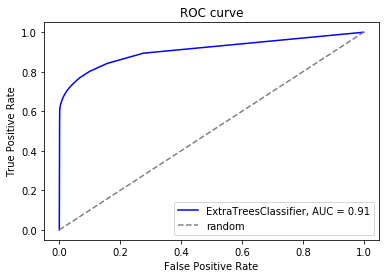

In [31]:
preds = predicted[:,1]
fpr, tpr, treshold = metrics.roc_curve(expected, preds)
roc_auc = metrics.auc(fpr, tpr)
pylab.title('ROC curve')
pylab.plot(fpr, tpr,'b', label = 'ExtraTreesClassifier, AUC = %0.2f' % roc_auc)
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.legend(loc = 'lower right')

In [32]:
predict = ExTC1.predict_proba(pred)[:,1]
predictedID = pd.concat([predId,pd.DataFrame(predict,columns=['DvaRavnoOdin'])],axis=1,ignore_index=False)

In [33]:
(predictedID['DvaRavnoOdin']>0.3).value_counts()

False    4283326
True       56627
Name: DvaRavnoOdin, dtype: int64

In [34]:
predictedID.head()

,PartnerID,CityID,DvaRavnoOdin
0,2,35,0.00
1,3,72,0.00
2,4,92,0.02
3,6,32,0.00
4,9,122,0.00


In [35]:
#y_Discount
#y_Points, y_Sertifikat, y_SellOut, y_Shock

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y_Discount, test_size=0.25, random_state=42,stratify=y_Discount,shuffle =True)

In [37]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC2 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC2, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC2.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC2.predict_proba(X_test)
labels =  ExTC2.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.98      1.00      0.99   1371921
          1       0.92      0.60      0.72     52492

avg / total       0.98      0.98      0.98   1424413

[[1369174    2747]
 [  21168   31324]]
0.7973681243772367
0.9191661806305671
Wall time: 10min 19s


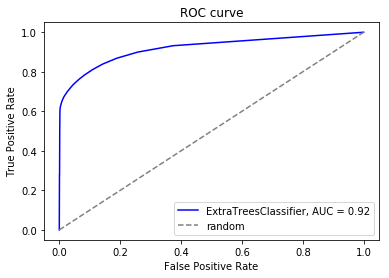

In [38]:
preds = predicted[:,1]
fpr, tpr, treshold = metrics.roc_curve(expected, preds)
roc_auc = metrics.auc(fpr, tpr)
pylab.title('ROC curve')
pylab.plot(fpr, tpr,'b', label = 'ExtraTreesClassifier, AUC = %0.2f' % roc_auc)
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.legend(loc = 'lower right')

In [39]:
predict = ExTC2.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['Discount'])],axis=1,ignore_index=False)
predictedID.head()

,PartnerID,CityID,DvaRavnoOdin,Discount
0,2,35,0.00,0.01
1,3,72,0.00,0.00
2,4,92,0.02,0.02
3,6,32,0.00,0.05
4,9,122,0.00,0.00


In [40]:
(predictedID['Discount']>0.3).value_counts()

False    4230003
True      109950
Name: Discount, dtype: int64

In [41]:
#y_Points
#y_Sertifikat, y_SellOut, y_Shock

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y_Points, test_size=0.25, random_state=42,stratify=y_Points,shuffle =True)

In [43]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC3 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC3, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC3.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC3.predict_proba(X_test)
labels =  ExTC3.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.98      1.00      0.99   1372051
          1       0.92      0.59      0.72     52362

avg / total       0.98      0.98      0.98   1424413

[[1369403    2648]
 [  21610   30752]]
0.7926830866838726
0.9201898999129449
Wall time: 10min 21s


In [44]:
predict = ExTC3.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['Points'])],axis=1,ignore_index=False)
predictedID.head()

,PartnerID,CityID,DvaRavnoOdin,Discount,Points
0,2,35,0.00,0.01,0.02
1,3,72,0.00,0.00,0.00
2,4,92,0.02,0.02,0.04
3,6,32,0.00,0.05,0.05
4,9,122,0.00,0.00,0.02


In [45]:
(predictedID['Discount']>0.3).value_counts()

False    4230003
True      109950
Name: Discount, dtype: int64

In [46]:
#y_Sertifikat
#y_SellOut, y_Shock

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y_Sertifikat, test_size=0.25, random_state=42,stratify=y_Sertifikat,shuffle =True)

In [48]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC4 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC4, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC4.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC4.predict_proba(X_test)
labels =  ExTC4.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1424327
          1       0.73      0.28      0.40        86

avg / total       1.00      1.00      1.00   1424413

[[1424318       9]
 [     62      24]]
0.6395317243340759
0.7026189202600311
Wall time: 5min 13s


In [49]:
predict = ExTC4.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['Sertifikat'])],axis=1,ignore_index=False)
predictedID.head()

,PartnerID,CityID,DvaRavnoOdin,Discount,Points,Sertifikat
0,2,35,0.00,0.01,0.02,0.0
1,3,72,0.00,0.00,0.00,0.0
2,4,92,0.02,0.02,0.04,0.0
3,6,32,0.00,0.05,0.05,0.0
4,9,122,0.00,0.00,0.02,0.0


In [50]:
(predictedID['Sertifikat']>0.1).value_counts()

False    4339638
True         315
Name: Sertifikat, dtype: int64

In [51]:
#y_SellOut
#y_Shock

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y_SellOut, test_size=0.25, random_state=42,stratify=y_SellOut,shuffle =True)

In [53]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC5 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC5, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC5.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC5.predict_proba(X_test)
labels =  ExTC5.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1419509
          1       0.86      0.48      0.62      4904

avg / total       1.00      1.00      1.00   1424413

[[1419142     367]
 [   2556    2348]]
0.7392671410425665
0.8777341332342938
Wall time: 9min 43s


In [54]:
predict = ExTC5.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['SellOut'])],axis=1,ignore_index=False)
predictedID.head()

,PartnerID,CityID,DvaRavnoOdin,Discount,Points,Sertifikat,SellOut
0,2,35,0.00,0.01,0.02,0.0,0.00
1,3,72,0.00,0.00,0.00,0.0,0.00
2,4,92,0.02,0.02,0.04,0.0,0.00
3,6,32,0.00,0.05,0.05,0.0,0.01
4,9,122,0.00,0.00,0.02,0.0,0.00


In [55]:
(predictedID['SellOut']>0.3).value_counts()

False    4328723
True       11230
Name: SellOut, dtype: int64

In [56]:
#y_Shock

In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y_Shock, test_size=0.25, random_state=42,stratify=y_Shock,shuffle =True)

from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC6 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC6, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC6.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC6.predict_proba(X_test)
labels =  ExTC6.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier
predict = ExTC6.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['Shock'])],axis=1,ignore_index=False)
predictedID.head()

In [ ]:
(predictedID['Shock']>0.3).value_counts()

In [ ]:
predictedID.head(40)

In [ ]:
predictedID.to_csv('Commun_pred_19122018.csv')

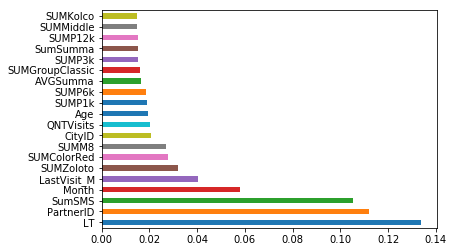

In [118]:
feat_importances = pd.Series(ExTC5.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [263]:
predict = ExTC.predict(pred)

In [282]:
predictedID_metall = pd.concat([predId,pd.DataFrame(predict,columns=['Zoloto'])],axis=1,ignore_index=False)

In [283]:
predictedID_metall.head()

,PartnerID,Zoloto
0,10,0
1,100,1
2,1000,1
3,1000037,1
4,1000038,1


In [284]:
predictedID_metall['Zoloto'].value_counts()

1    2058236
0     590714
Name: Zoloto, dtype: int64